# Métodos de filtrado

En este notebook se revisarán los conceptos de:

1. Métodos de filtrado para regresión
2. Métodos de filtrado para clasificación
3. Métodos de filtrado en un problema realista
4. Métodos *wrapper*
5. Métodos *embedded*

Primero cargamos librerías y funciones necesarias, incluyendo las del módulo `utils`:

In [1]:
from utils import CM_BRIGHT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Métodos de filtrado para regresión

Vamos a analizar un par de métodos de [filtrado](http://scikit-learn.org/stable/modules/feature_selection.html) para regresión mediante un ejemplo sencillo:

* [f_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)
* [mutual_info_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)

#### Ejemplo 
Se tienen tres variables $x_1, x_2,x_3$. Las tres son aleatorias y se distribuyen uniformemente en el intervalo $[0,1]$. La salida depende de estas variables de la forma: 

$$y = x_1 + \sin{(6\pi x_2)} + 0.1\mathcal{N}(0, 1),$$

Esto es:

* $y$ depende linealmente de $x_1$
* $y$ depende no linealmente de $x_2$
* $y$ no depende de $x_3$

Por tanto, $x_3$ es una variable irrelevante para $y$. Veamos qué nos dicen nuestros test de filtrado de selección de características.

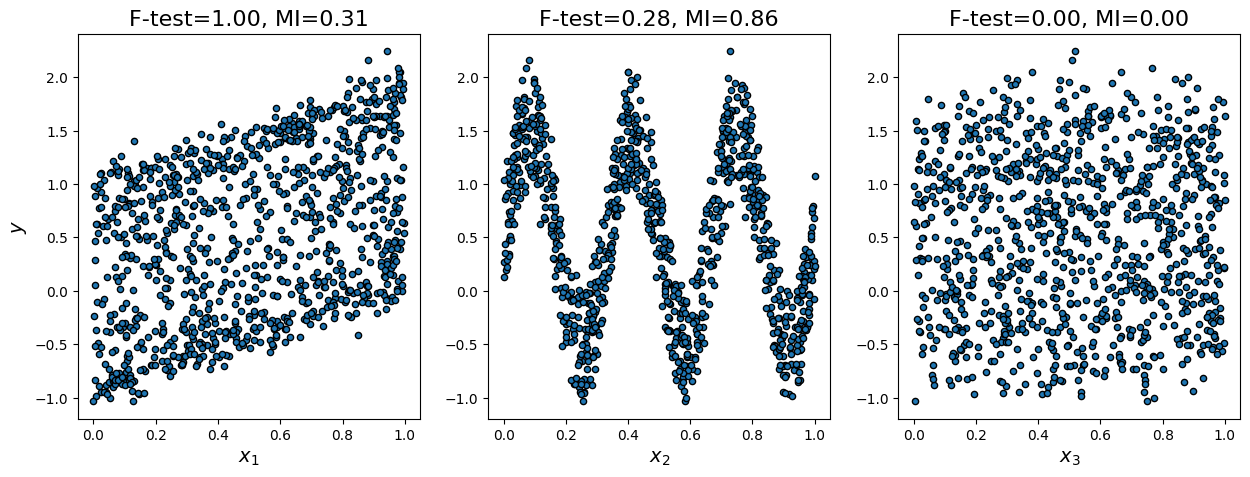

In [11]:
# Este ejemplo, tomado de:
# http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py

from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
#mi /= np.max(mi)

# Visualización
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

<div class = "alert alert-success">
EJERCICIO 3.1: ¿Cómo interpretáis estos resultados?
</div>

## 2. Métodos de filtrado para clasificación

Vamos a analizar los mismos métodos de [filtrado](http://scikit-learn.org/stable/modules/feature_selection.html) que en el caso de regresión, aplicados ahora para distintos problemas de clasificación:

* [f_classif](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)
* [mutual_info_classif](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

### 2.1 Problema de clasificación linealmente separable

En este problema, la variable $x_1$ define un problema linealmente separable y constituye la variable informativa. $x_2$ representa una variable redundante, mientras que $x_3$ y $x_4$ son variables ruidosas que no aportan información.


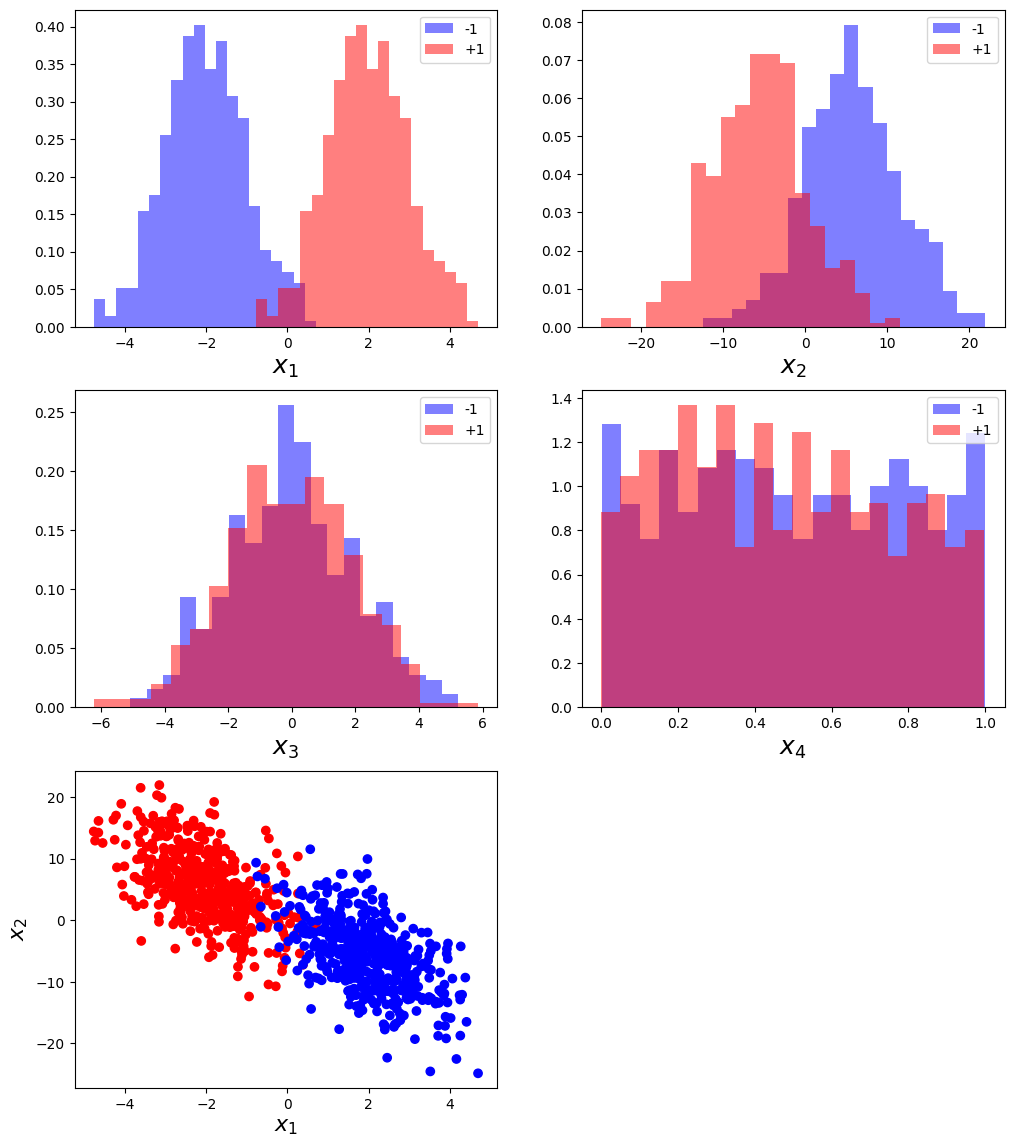

In [12]:
# toy example: linearly separable problem
np.random.seed(0)

# Parámetros
N      = 1000
mu     = 2
sigma1 = 1
sigma2 = 5

# Variables auxiliares
unos  = np.ones(int(N/2))
rand2 = np.random.randn(int(N/2),1)

# Características
y  = np.concatenate([-1*unos,unos]) 
X1 = np.concatenate([-mu + sigma1*rand2,mu + sigma1*rand2])
X2 = sigma2*np.random.randn(N,1) - 3*X1

X3 = 2*np.random.randn(N,1)
X4 = np.random.rand(N,1)

X  = np.hstack((X1,X2,X3,X4))

# Visualización
plt.figure(figsize=(12, 14))
for i in range(4):
    plt.subplot(3, 2, i + 1)
    plt.hist(X[y<0,i],bins=20, density=True, alpha=0.5, label='-1',color='b')
    plt.hist(X[y>0,i], bins=20, density=True, alpha=0.5, label='+1',color='r')
    plt.legend(loc='upper right')
    plt.xlabel("$x_{}$".format(i + 1), fontsize=18)

plt.subplot(3, 2, 5)
plt.scatter(X1,X2,c=y.reshape(-1,1),cmap=CM_BRIGHT)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.show()

Apliquemos los métodos de filtrado:

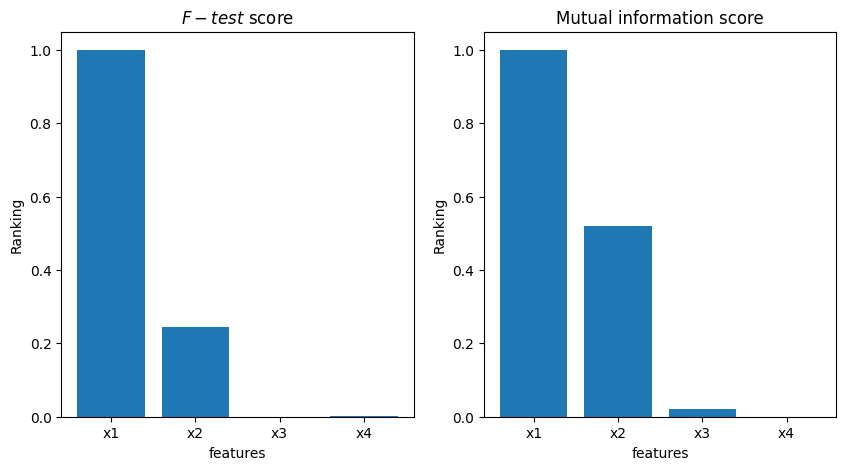

In [13]:
from sklearn.feature_selection import f_classif, mutual_info_classif

featureNames = ['x1','x2','x3','x4']

# do calculations
f_test, _ = f_classif(X, y)
f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),featureNames)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

<div class = "alert alert-success">
EJERCICIO 3.2: ¿Cómo interpretáis estos resultados?
</div>

### 2.2 Problema de clasificación no linealmente separable

Vamos a analizar el problema XOR que, como ya sabéis, está definido (es decir, resuelto) por las variables $x_1$ y $x_2$; recordad lo de los cuadrantes. Añadimos además dos variables relevantes $x_3$ y $x_4$, con capacidad discriminatoria y que por tanto pueden ayudar a mejorar las prestaciones del problema de clasificación bajo estudio. Por último, se incluyen 20 variables ruidosas irrelevantes.


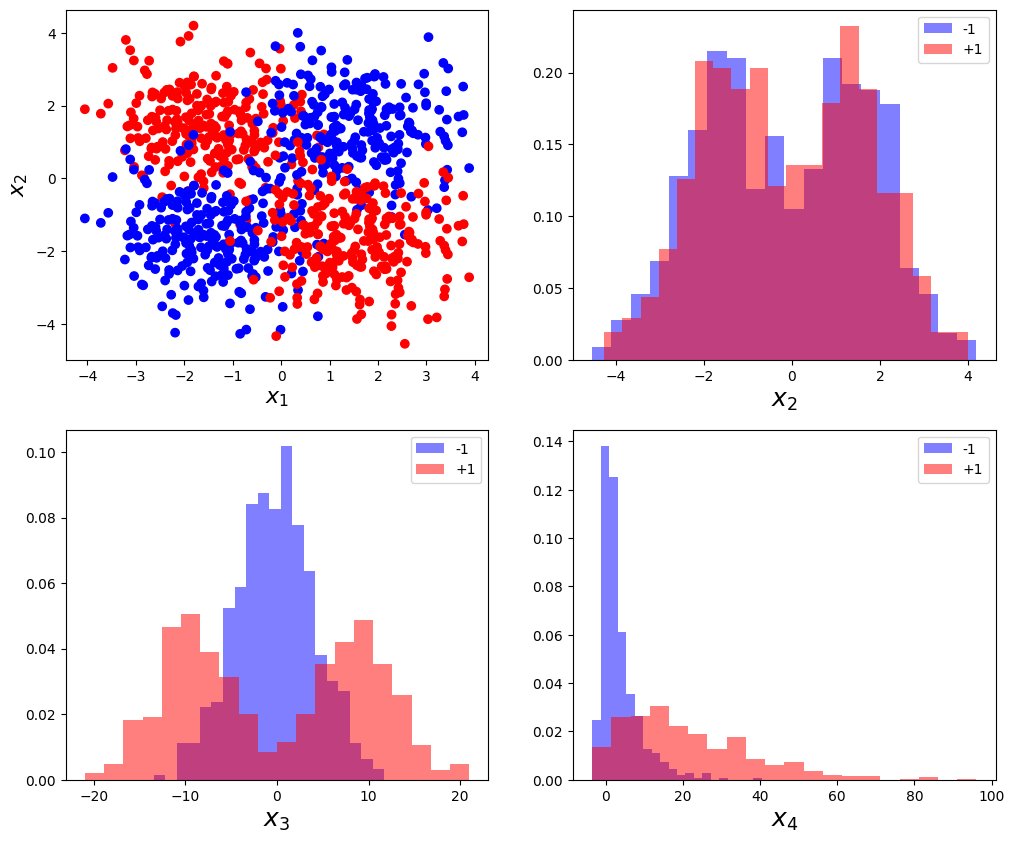

In [17]:
np.random.seed(0)

# -- parameters
N     = 1000
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])

# fijaos como X3 y X4 son combinaciones de X1 y X2; sabemos que el problema se soluciona con ambas variables,
# pero que ninguna de las dos por separado nos sirven. X3 y X4 tienen cierta capacidad discriminatoria
X3 = 3*(X1+X2) + np.sqrt(2)*np.random.randn(N,1)
X4 = 2*np.square((X1+X2)) + np.sqrt(2)*np.random.randn(N,1)

E  = 2*np.random.randn(N, 20) # noisy variables

X  = np.hstack((X1,X2,X3,X4,E))

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)

plt.scatter(X1,X2,c=y.reshape(-1,1), cmap=CM_BRIGHT)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

for i in range(3):
    plt.subplot(2, 2, i + 2)
    plt.hist(X[y<0,i+1],bins=20, density=True, alpha=0.5, label='-1',color='b')
    plt.hist(X[y>0,i+1], bins=20, density=True, alpha=0.5, label='+1',color='r')
    plt.legend(loc='upper right')
    plt.xlabel("$x_{}$".format(i + 2), fontsize=18)

plt.show()

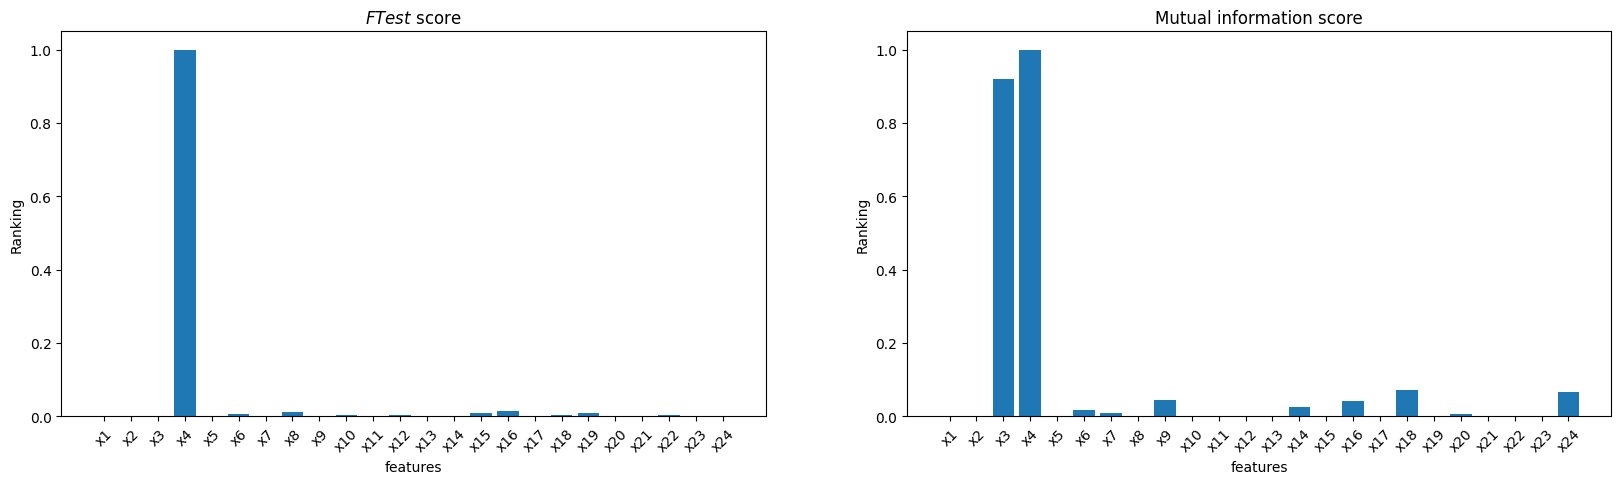

In [15]:
# son 24 variables porque hay 4 declaradas arriba (X1, X2, X3, X4) y 20 variables aleatorias que son ruido: en total 24.
featureNames = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14',
                'x15','x16','x17','x18','x19','x20','x21','x22','x23','x24']


# do calculations
f_test, _ = f_classif(X, y)
f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

<div class = "alert alert-success">
EJERCICIO 3.3: ¿Cómo interpretáis estos resultados?
</div>

## 3. Métodos de filtrado sobre problema realista

Vamos a aplicar los métodos de filtrado sobre la base de datos  de viviendas [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction)

Recordamos que para cada vivienda, se tienen los siguientes atributos, características o features:

| Atributo | descripción |
| :- |:- |
|*id*| identificador de la vivienda|
| *date*| fecha
| *price*| precio
| *bedrooms*| número de habitaciones
| *bathrooms*| número de baños/aseos
| *sqtf_living*| superficie habitable (en pies al cuadrado)
| *sqft_lot*| superficie de la parcela (en pies al cuadrado)
| *floors*| número de plantas
| *waterfront*| indica si la vivienda tiene acceso a un lago
| *view*| tipo de vista (variable numérica)
| *condition*| condición de la vivienda (variable númerica)
| *grade*| medida de la calidad de la construcción (variable numérica)
| *sqft_above*| superficie por encima del suelo (en pies al cuadrado)
| *sqft_basement*| superficie del sótano (en pies al cuadrado)
| *yr_built*| año de construcción de la vivienda
| *yr_renovated*| año de renovación de la vivienda
| *lat*| latitud de la parcela
| *long*| longitud de la parcela
| *sqft_living15*| superficie habitable promedio de los 15 vecinos más cercanos 				
| *sqft_lot15*| superficie de la parcela promedio de los 15 vecinos más cercanos

NOTA: No me detengo mucho en este dataset porque en el siguiente notebook vamos a darle bastante!


In [18]:
# Veremos este análisis en detalle en el notebook de análisis exploratorio - por ahora, creéroslo!

# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv")

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertimos las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2017 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

In [19]:
house_data.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
bedrooms,3.000000,3.000000,2.000000,4.000000,3.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
sqm_living,109.625587,238.760813,71.535341,182.089958,156.077107
sqm_lot,524.902176,672.803816,929.030400,464.515200,750.656563
floors,1.000000,2.000000,1.000000,1.000000,1.000000
waterfront,0.000000,0.000000,0.000000,0.000000,0.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
condition,3.000000,3.000000,3.000000,5.000000,3.000000
grade,7.000000,7.000000,6.000000,7.000000,8.000000


Vamos a analizar la correlación entre variables:

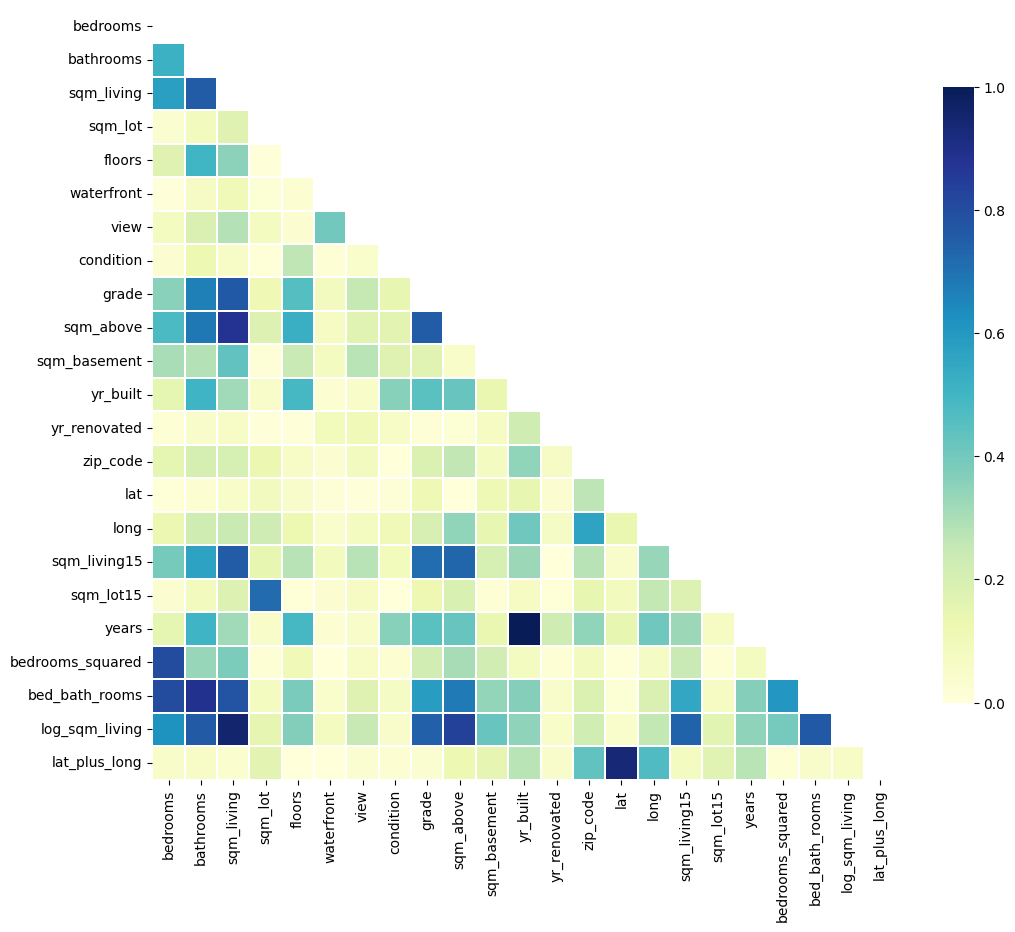

In [21]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(house_data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

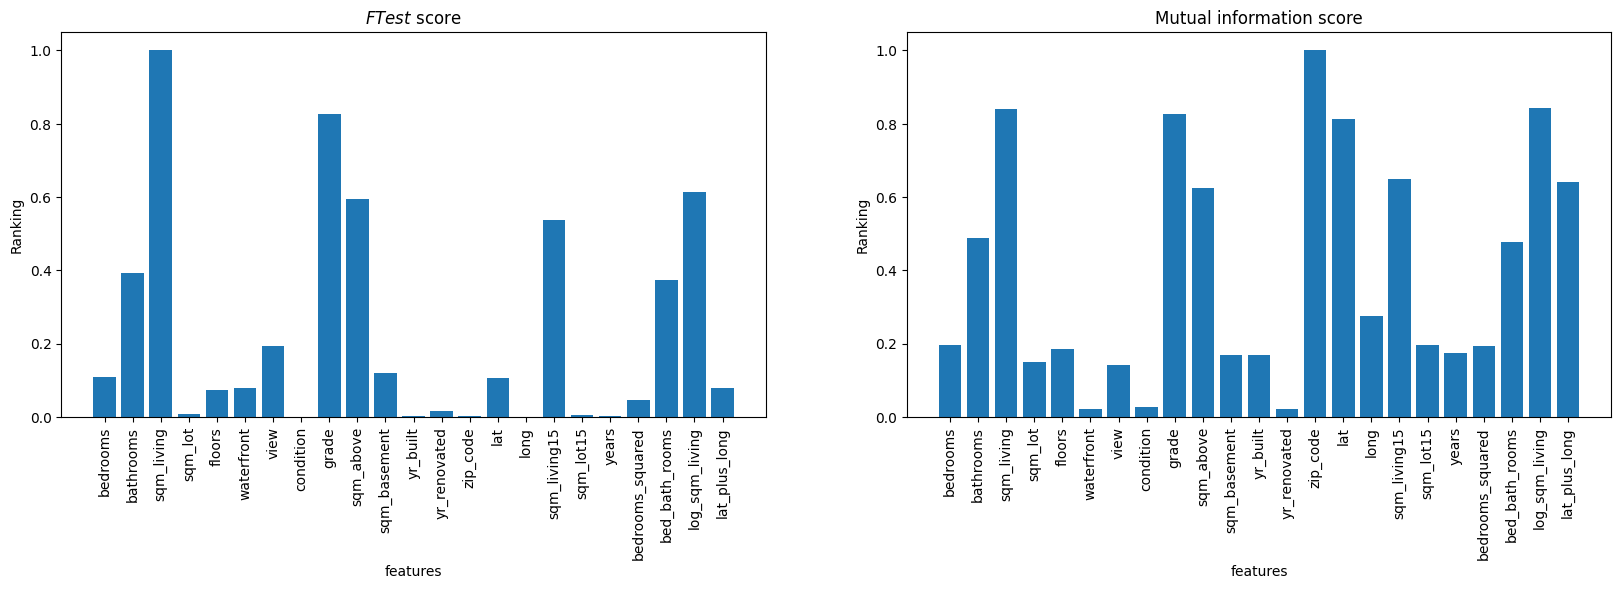

In [22]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# estudiamos los dos métodos de filtrado
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# visualización
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

<div class = "alert alert-success">
EJERCICIO 3.4: Las variables seleccionadas, ¿concuerdan con tu intuición?
</div>

## 4. Métodos Wrapper

Estos métodos utilizan un algoritmo de machine learning como caja negra para rankear distintos subconjuntos de variables de acuerdo a su capacidad predictiva. Normalmente se usan en mediante procedimientos hacia delante/detrás en combinación con validación cruzada. Vamos a ver, simplemente, cómo aplicarlos correctamente.

#### *The wrong and right way to do cross-validation*

Este ejemplo ha sido inspirado en *7.10.2 The Wrong and Right Way to Do Cross-validation* del libro
"The Elements of Statistical Learning". Hastie, Tibshirani, Friedman

Este código ejecuta 500 veces un experimento: en cada iteración, genera un nuevo dataset, donde los predictores son variables aleatorias, ruidosas; a continuación, realiza una selección de características, y luego utiliza un KNN con `n_neighbours=1` para evaluar las prestaciones del subconjunto seleccionado, con validación cruzada de 5-folds.

Error rate (%): 3.5719999999999974


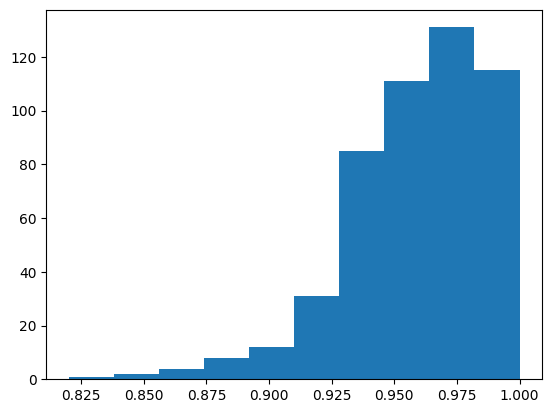

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif


# This is the WRONG way

np.random.seed(0)
score = []

for i in range(500): # This is run for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors are random variables!!
    
    # Note here, the ranking and selection is performed outside the CV loop
    f_test, _ = f_classif(X, y)
    f_test /= np.max(f_test)
    
    
    ranking = np.argsort(f_test)[::-1] 
    selected = ranking[0:50]
    Xs = X[:,selected]
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(Xs):
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

<div class = "alert alert-success">
EJERCICIO 3.5: ¿Qué os parece el resultado? ¿Encaja con vuestra intuición? ¿Diríais que es correcto o incorrecto? ¿Por qué?
</div>

Error rate (%): 52.664


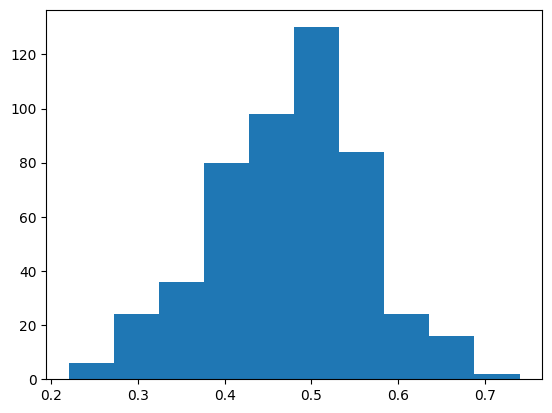

In [24]:
# This is the RIGHT way

np.random.seed(0)
score = []

for i in range(500): # This runs for a number of experiments. Montecarlo simulation
    
    # Create toy example
    N = 50
    y = np.concatenate([-1*np.ones(int(N/2)),np.ones(int(N/2))]) # target
    X = np.random.randn(N, 5000)                       # predictors, again random variables
    
    # 1-neighbor classifier
    knn = KNeighborsClassifier(n_neighbors=1)
    
    # 5-fold CV
    kf  = KFold(n_splits=5, shuffle = True)
    score_i = []
    
    for train, validation in kf.split(X):
        
        # Note here, the ranking and selection is performed inside the CV loop
        f_test, _ = f_classif(X[train,:], y[train])
        f_test /= np.max(f_test)
        ranking = np.argsort(f_test)[::-1] 
        selected = ranking[0:50]
        
        Xs = X[:,selected]
        
        knn.fit(Xs[train,:],y[train])
        accuracy = knn.score(Xs[validation,:],y[validation])
        
        score_i.append(accuracy) 
    
    score.append(np.mean(score_i))

print("Error rate (%): " + str((1-np.mean(score))*100))

plt.hist(score)
plt.show()

El problema del primer enfoque es que la selección de características se realiza antes del bucle de validación cruzada en lugar de dentro de él. Esto significa que se utiliza información de todo el conjunto de datos para seleccionar las características, y ¿qué provoca esto? en efecto: data leakage. El data leakage (o contaminación de los datos) ocurre cuando durante el proceso de entrenamiento se utiliza información que no estaría disponible en el momento de la predicción, lo que lleva a estimaciones de rendimiento excesivamente optimistas.

Vamos: la misma razón por la cual no podemos realizar un análisis/preprocesamiento antes de dividir en train y test.

El enfoque correcto es incluir el paso de selección de características dentro del bucle de validación cruzada, de modo que para cada fold, la selección de características se realice utilizando sólo los datos de entrenamiento. Esto asegura que los datos de validación permanezcan ocultos y no influyan en el modelo o en el proceso de selección de características, proporcionando una estimación más precisa del rendimiento del modelo.

## 5. Métodos embedded

Vamos a trabajar directamente sobre la base de datos  de viviendas [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), así que lo primero es cargar los datos:

In [25]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2015 - house_data['yr_built']
#house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
#house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
#house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
#house_data['lat_plus_long']    = house_data['lat']*house_data['long']

house_data.head().T

,0,1,2,3,4
price,221900.000000,538000.000000,180000.000000,604000.000000,510000.000000
bedrooms,3.000000,3.000000,2.000000,4.000000,3.000000
bathrooms,1.000000,2.250000,1.000000,3.000000,2.000000
sqm_living,109.625587,238.760813,71.535341,182.089958,156.077107
sqm_lot,524.902176,672.803816,929.030400,464.515200,750.656563
floors,1.000000,2.000000,1.000000,1.000000,1.000000
waterfront,0.000000,0.000000,0.000000,0.000000,0.000000
view,0.000000,0.000000,0.000000,0.000000,0.000000
condition,3.000000,3.000000,3.000000,5.000000,3.000000
grade,7.000000,7.000000,6.000000,7.000000,8.000000


In [26]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

Vamos a aprovechar para usar un normalizador: [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [27]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled = scaler.transform(X_test)

Datos entrenamiento:  (16209, 19)
Datos test:  (5404, 19)


Y vamos a aprovechar la capacidad de Lasso para seleccionar variables:

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..........................................alpha=0.1; total time=   1.5s
[CV] END ..........................................alpha=0.1; total time=   1.2s
[CV] END ..........................................alpha=0.1; total time=   0.9s
[CV] END ..........................................alpha=0.1; total time=   0.9s
[CV] END ..........................................alpha=0.1; total time=   1.2s
[CV] END ..........................alpha=0.37926901907322497; total time=   1.7s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.8s
[CV] END ..........................alpha=0.37926901907322497; total time=   0.9s
[CV] END ..........................alpha=0.37926901907322497; total time=   2.0s
[CV] END ..........................alpha=0.37926901907322497; total time=   1.8s
[CV] END ............................alpha=1.438449888287663; total time=   0.8s
[CV] END ............................alpha=1.43

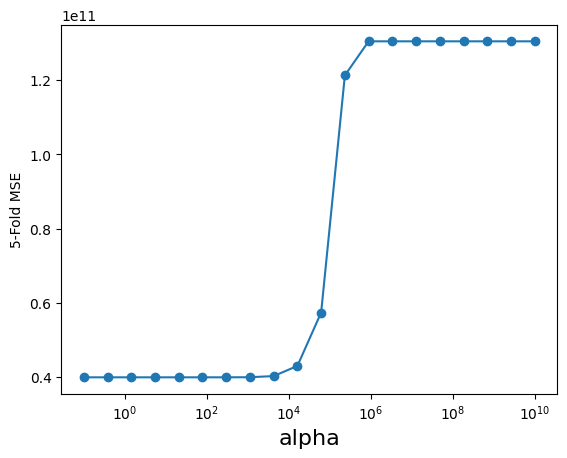

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1,10,20) # Podéis subir esto a 50, yo lo dejo en 20 para que tarde menos
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

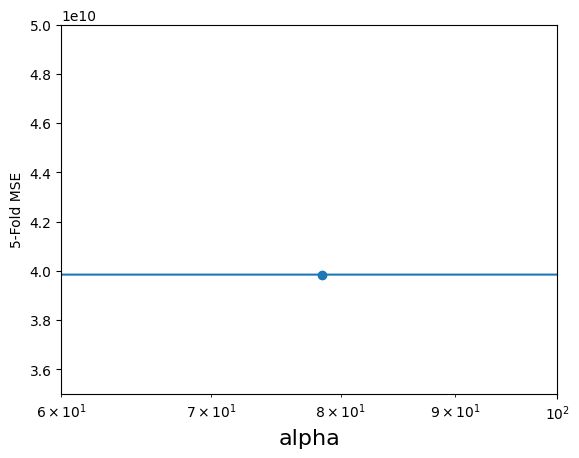

In [38]:
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.xlim(60, 100)
plt.ylim(0.35e11, 0.5e11)
plt.show()


In [37]:
grid.best_params_['alpha']

78.47599703514615

In [39]:
from sklearn.metrics import mean_squared_error

alpha_optimo = 20000#grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 4.34e+10
MSE Modelo Lasso (test) : 4.87e+10
RMSE Modelo Lasso (train): 2.08e+05
RMSE Modelo Lasso (test) : 2.21e+05
bedrooms -0.0
bathrooms 0.0
sqm_living 144821.98957746793
sqm_lot -0.0
floors 0.0
waterfront 33024.779841582116
view 37184.968020326116
condition 2213.0540350069195
grade 109674.47264608381
sqm_above 0.0
sqm_basement 0.0
yr_built -42312.004370853516
yr_renovated 0.0
zip_code -0.0
lat 66455.77420111367
long -0.0
sqm_living15 1832.6183316307363
sqm_lot15 -0.0
years 605.534060275221


Como puede apreciarse, con este algoritmo hemos conseguido "desactivar" algunas variables (*sqm_lot*, *sqm_basement*, *long*, *bedrooms_squared*, *bed_bath_rooms*), lo que mejora la interpretabilidad del modelo a costa de aumentar ligeramente el error en test.

No obstante, siguen apareciendo algunas incoherencias con respecto al valor de los coeficientes, como por ejemplo el asociado a la variable *bedrooms* que tiene valor negativo. Si aumentamos el parámetro de regularización y observamos los resultados obtenidos hemos aumentado el error, pero a cambio:

1. Tenemos un modelo más sencillo (menos variables al haber muchos coeficientes nulos) y por tanto, menos susceptible a sufrir overfitting
2. Mejoramos la interpretabilidad del modelo, las variables supervivientes (con coeficiente distintos de cero) parecen concordar con nuestra intuición sobre problema a resolver

Y una vez llegados a este punto, ¿qué podemos hacer? El error de entrenamiento/validación y test es similar, pero todavía es muy alto, así que: 

1. Se podrían definir nuevas variables que nos ayuden a mejorar el error de predicción (mse)
2. Modificar el parámetro de regularización, para mantener el compromiso entre sencillez/interpretabilidad del modelo y error de predicción (MSE).